In [56]:
import json
import pickle

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import osmnx as ox
import pandas as pd
from pyproj import Transformer
from scipy.optimize import least_squares

In [57]:
## Reverse-engineered matching road graph nodes
# Nodes in unknown projection in the dataset
node_ids = [105, 741, 90, 732, 567, 580, 924, 6099, 59, 601, 1351, 133]
# Nodes in WGS84 in the other graph
other_node_ids = [6091, 3891, 3815, 4582, 3890, 3808, 3809, 10529, 6927, 4237, 3835, 4218]

In [58]:
## Build other road graph
nodes_path = "node_shenzhen.csv"
edges_path = "edge_shenzhen.csv"

nodes_df = pd.read_csv(nodes_path)
edges_df = pd.read_csv(edges_path)

# https://github.com/tsinghua-fib-lab/City-Camera-Trajectory-Data/blob/main/example/usage.ipynb
# nodes = [
#     (
#         int(nid),
#         {
#             "id": int(nid),
#             "x": float(lon),
#             "y": float(lat),
#             "has_camera": bool(hasc)
#         }
#     ) for _, (nid, lon, lat, hasc) in nodes_df.iterrows()
# ]
# edges = [
#     (
#         int(o),
#         int(d),
#         {
#             "id": i,
#             "od": [int(o), int(d)],
#             "class": c,
#             "points": [[float(x) for x in p.split("-")] for p in geo.split("_")],
#             "length": float(l)
#         }
#     ) for i, (o, d, c, geo, l) in edges_df.iterrows()
# ]
#
# for e in edges:
#     e[2]["geometry"] = shp.LineString(e[2]["points"])
#
# road_graph = nx.DiGraph()
# road_graph.add_nodes_from(nodes)
# road_graph.add_edges_from(edges)
# road_graph.graph["crs"] = "WGS84"
#
# # Visualize other road graph
# fig, ax = ox.plot_graph(
#     nx.MultiDiGraph(road_graph),
#     bgcolor="white",
#     node_size=2,
#     node_color="blue",
#     edge_color="black")
#
# for node, data in road_graph.nodes(data=True):
#     if node in other_node_ids:
#         x, y = data["x"], data["y"]
#         ax.text(x, y, str(node), fontsize=1, color="red", ha="center", va="center")
#
# fig.savefig("other_road_graph.svg")
# plt.show()

In [59]:
# Fetch node coordinates
other_nodes_dict = dict()
for _, row in nodes_df.iterrows():
    node_id = int(row["NodeID"])
    if node_id in other_node_ids:
        other_nodes_dict[node_id] = {"lon": float(row["Longitude"]), "lat": float(row["Latitude"])}

nodes_dict = dict()
dataset_path = "../datasets/UrbanVehicle"
with open(f"{dataset_path}/map.json", mode="r", encoding="utf-8") as file:
    items = json.load(file)

    for item in items:
        node_id = item["id"]
        if item["type"] == "node" and node_id in node_ids:
            nodes_dict[node_id] = {"x": item["xy"][0], "y": item["xy"][1]}

In [60]:
## Reverse-engineering of GPS coordinates
gps_points = np.array(
    [[other_nodes_dict[node_id]["lon"], other_nodes_dict[node_id]["lat"]] for node_id in other_node_ids]).astype(
    np.float64)
xy_points = np.array([[nodes_dict[node_id]["x"], nodes_dict[node_id]["y"]] for node_id in node_ids]).astype(np.float64)


# Assumed projection includes rotation, translation and scaling
def affine_transform(params, xy_points):
    a, b, c, d, e, f = params
    x, y = xy_points[:, 0], xy_points[:, 1]
    lon = a * x + b * y + e
    lat = c * x + d * y + f
    return np.vstack([lon, lat]).T


def error_func(params, xy_points, gps_points):
    transformed = affine_transform(params, xy_points)
    return (transformed - gps_points).flatten()


initial_guess = [1, 0, 0, 1, 0, 0]  # identity
result = least_squares(error_func, initial_guess, method="lm", args=(xy_points, gps_points))

# [-4.25994981e-06 -8.74119271e-06  8.11700876e-06 -3.95042166e-06,  1.14014210e+02  2.26438070e+01]
opt_params = result.x

transformed_gps_points = affine_transform(opt_params, xy_points)
print("Actual GPS points:")
print(gps_points)
print("Transformed GPS points:")
print(transformed_gps_points)

print("Mean error: ", np.mean(np.sqrt(np.sum(np.power(transformed_gps_points - gps_points, 2), axis=1))))

[-4.25994981e-06 -8.74119271e-06  8.11700876e-06 -3.95042166e-06
  1.14014210e+02  2.26438070e+01]
Actual GPS points:
[[114.040536  22.656135]
 [114.039998  22.645723]
 [114.029911  22.646878]
 [114.03589   22.6473  ]
 [114.030613  22.649589]
 [114.037547  22.599173]
 [114.035699  22.601163]
 [114.005028  22.676499]
 [114.005181  22.679942]
 [114.055657  22.625086]
 [114.050207  22.625298]
 [114.060067  22.615359]]
Transformed GPS points:
[[114.04052899  22.65611959]
 [114.03997597  22.64572208]
 [114.02988292  22.64687848]
 [114.03585077  22.64730729]
 [114.03059047  22.64959076]
 [114.03755338  22.59917522]
 [114.03568483  22.6011462 ]
 [114.0049825   22.67660391]
 [114.00526788  22.67984663]
 [114.05564635  22.62508374]
 [114.05031317  22.62528707]
 [114.06005677  22.61538402]]
Mean error:  4.552703110455817e-05


In [61]:
# Fetch OSMnx graph with GPS coordinates
# road_graph_ox = ox.graph_from_bbox(bbox=(113.95140, 22.57439, 114.06950, 22.70050), network_type="drive",
#                                    simplify=False)
# ox.save_graphml(road_graph_ox, filepath="road_graph_ox.xml", encoding="utf-8")
road_graph_ox = ox.load_graphml(filepath="road_graph_ox.xml")

trajectories = []
with open(f"{dataset_path}/trajectories.json", mode="r", encoding="utf-8") as file:
    for line in file:
        trajectory = json.loads(line)
        trajectory["xyt"].sort(key=lambda l: l[2])
        trajectory["xy"] = np.array([[point[0], point[1]] for point in trajectory["xyt"]])
        del trajectory["xyt"]
        trajectories.append(trajectory)

cameras = list()
with open(f"{dataset_path}/cameras.json", mode="r", encoding="utf-8") as file:
    for line in file:
        camera = json.loads(line)
        cameras.append({"camera_id": camera["camera_id"], "x": camera["position"][0], "y": camera["position"][1]})

camera_coordinates = np.array([[camera["x"], camera["y"]] for camera in cameras])

road_graph: nx.DiGraph
with open("road_graph_nsl.pickle", mode="rb") as file:
    road_graph = pickle.load(file)

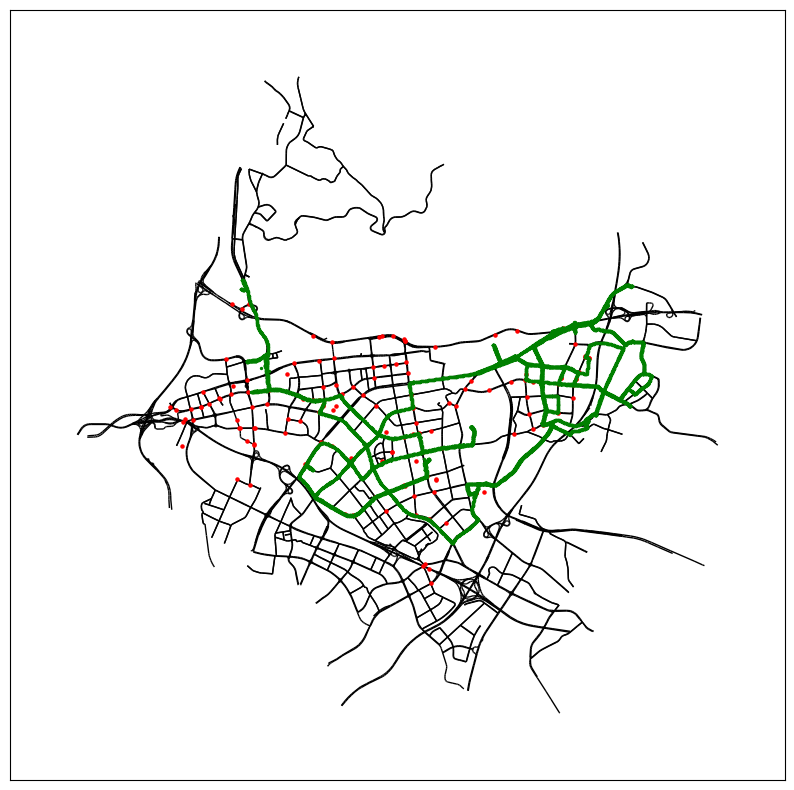

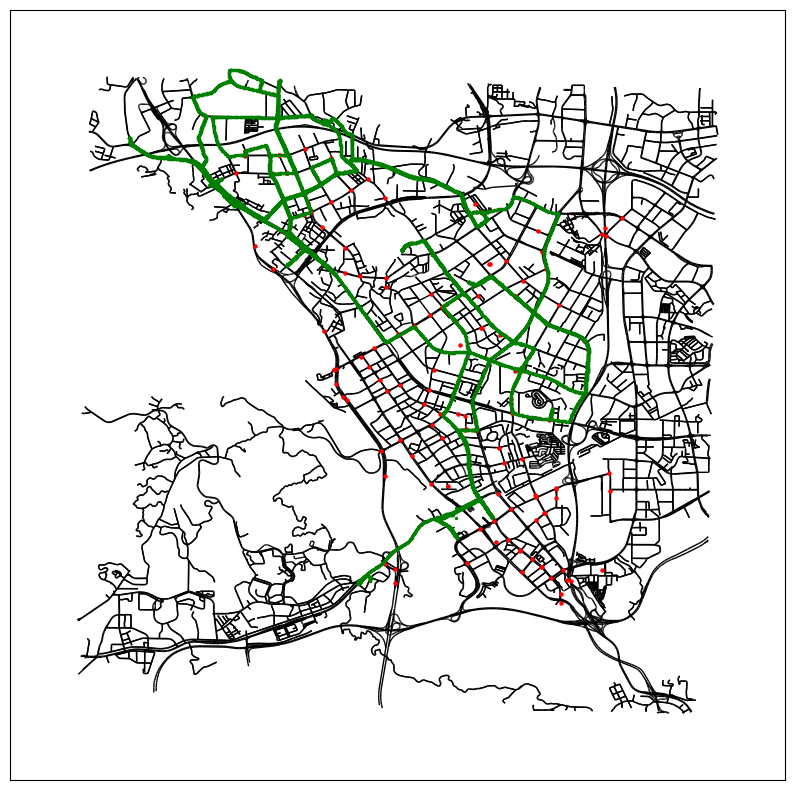

In [62]:
index = 8

# Draw road graph with dataset information
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

nx.draw_networkx_edges(road_graph, nx.get_node_attributes(road_graph, "pos"), arrows=False, ax=ax)
ax.scatter(camera_coordinates[:, 0], camera_coordinates[:, 1], s=5, c="red")
ax.scatter(trajectories[index]["xy"][:, 0], trajectories[index]["xy"][:, 1], s=2, c="green")

plt.savefig("road_graph.svg")
plt.show()

# Draw road graph with reverse-engineered information
camera_coordinates = affine_transform(opt_params, camera_coordinates)
trajectory = affine_transform(opt_params, trajectories[index]["xy"])
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32650", always_xy=True)

for coord in camera_coordinates:
    lon, lat = coord
    x, y = transformer.transform(lon, lat)
    coord[0] = x
    coord[1] = y

for coord in trajectory:
    lon, lat = coord
    x, y = transformer.transform(lon, lat)
    coord[0] = x
    coord[1] = y

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

road_graph_ox = ox.project_graph(road_graph_ox, to_crs="EPSG:32650")
pos = {node: (data['x'], data['y']) for node, data in road_graph_ox.nodes(data=True)}
nx.draw_networkx_edges(road_graph_ox, pos, arrows=False, ax=ax)
ax.scatter(camera_coordinates[:, 0], camera_coordinates[:, 1], s=5, c="red")
ax.scatter(trajectory[:, 0], trajectory[:, 1], s=2, c="green")

plt.savefig("road_graph_ox.svg")
plt.show()